# MCMC On Posteriors With Improper Priors

MCMC (Markov Chain Monte Carlo) requires a posterior probability distribution to sample from.
This means that one cannot sample from a likelihood, if one wishes to sample the parameters of a model. This is because the likelihood is a probability distribution of the *data*, conditioned on the parameters, rather than a probability distribution of the parameters. If our goal were to sample data sets, given a set of parameters we know to be true, the likelihood would be the right function to use.
However, most inference problems in science are concerned with sampling the parameters of a model, which presumably hold some information of interest about the underlying process that generated the data.

Even so, in many applications, researchers specify the likelihood and then use MCMC to infer the distribution of the parameters, without explicitly specifying the prior. But that doesn't mean the model is without prior. In fact, it cannot be in order for MCMC to work. The implicit assumption in this case is that the priors are flat (all values of the parameters are equally probable) and infinite. This runs the risk of making the posterior improper, that is, diverging, so that it does not integrate to 1. This is in general a bad property to have for a probability distribution, and for MCMC in particular. It's worth noting that this doesn't have to be true: if the likelihood function is well behaved, the posterior might still integrate to 1 even if the prior is improper. The key thing here is that this needs to be checked; for complex problems, this might be hard to do.

Here, I advocate that explicitly specifying the prior is always a good idea, and try to show some ways where not specifying priors can go very wrong.

In [47]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cmap

import numpy as np
import scipy.stats

## Exponential Decay of a Transient


This example is inspired by Steve Gull, via David MacKay.
Suppose an astronomical transient
occurs at time $t=0$, and has a brightness that
decays exponentially over time:

\begin{align}
\mathrm{Brightness}(t) &=
\left\{
\begin{array}{lr}
Ae^{-\frac{t}{L}}, & t \geq 0\\
0,                 & \mathrm{otherwise}.
\end{array}
\right.
\end{align}

Suppose we observe the object between times $t=t_{\rm min}$ and
$t=t_{\rm max}$, and we want to know the value of $L$, but don't
particularly care about $A$. We observe $N$ photons, and their
arrival times $\{t_1, t_2, ..., t_N\}$.
The probability distribution for the arrival times
$\{t_i\}$
given $L$ (and $N$, which we consider to be prior information)
is
\begin{align}
p(t_1, t_2, ..., t_N | L)
&\propto \prod_{i=1}^N e^{-t_i/L}.
\end{align}
This is the probability distribution for the data given the
parameters, which will give us the likelihood function once
we plug in the observed data. However, we need to normalise
it first, as the observed photon arrival times must be between
$t_{\rm min}$ and $t_{\rm max}$:
\begin{align}
p(t_1, t_2, ..., t_N | L)
&= \prod_{i=1}^N
\frac{e^{-t_i/L}}
     {\int_{t_{\rm min}}^{t_{\rm max}} e^{-t_i/L} dt_i}\\
&= \prod_{i=1}^N
\frac{e^{-t_i/L}}
     {L\left[e^{-t_{\rm min}/L} - e^{-t_{\rm max}/L}\right]}\\
&= L^{-N}\left[e^{-t_{\rm min}/L} - e^{-t_{\rm max}/L}\right]^{-N}
e^{-\frac{\sum_{i=1}^N t_i}{L}}.
\end{align}


Let's code up the likelihood for this problem:

In [2]:
logmin = -100000000.0

class TransientLikelihood(object):
    
    def __init__(self, times, tmin, tmax):
        self.times = times
        self.tmin = tmin
        self.tmax = tmax
        self.n = times.shape[0]
        
    def likelihood(self, pars):
        #amp = pars[0] # amplitude is first parameter
        ll = pars[0] # decay time scale is first parameter
        
        like = np.log(ll**(-self.n)\
                *(np.exp(-self.tmin/ll) - np.exp(-self.tmax/ll))**(-self.n)\
                *np.exp(-self.times.sum()/ll))
                
        if not np.isfinite(like):
            return logmin
        else:
            return like
    
    def __call__(self, pars):
        return self.likelihood(pars)

Next step: let's make some data:

In [26]:
np.random.seed(0)

ll = 10.3                     # True value of L
n = 20                        # Number of data points
t_min, t_max = 0.0, 15.0
t = []
for i in range(0, n):
    while True:
        tt = -ll*np.log(np.random.rand())
        if tt > t_min and tt < t_max:
            break
    t.append(tt)

t = np.array(t)

<IPython.core.display.Javascript object>


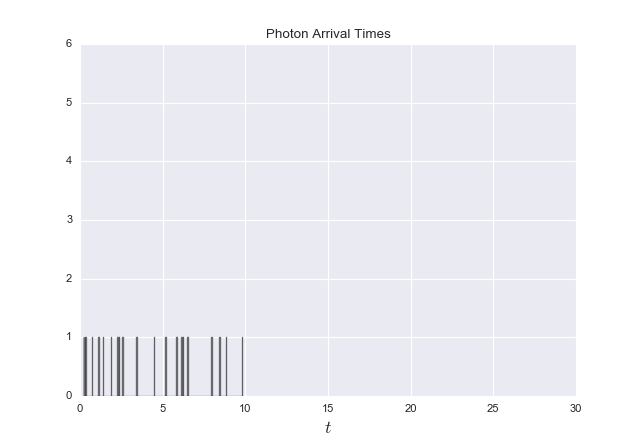

In [27]:
plt.figure()
plt.hist(t, bins=100, color="k", alpha=0.5)
plt.xlabel("$t$", fontsize=16)
plt.xlim([0.0, 30.0])
plt.ylim([0, 6])
plt.title("Photon Arrival Times")
plt.show()



What's the likelihood of the data given this model?

In [28]:
llike = TransientLikelihood(t, t_min, t_max)

In [29]:
llike([2])

-57.044617751153282

let's plot the log-likelihood as a function of the parameter $L$:

<IPython.core.display.Javascript object>


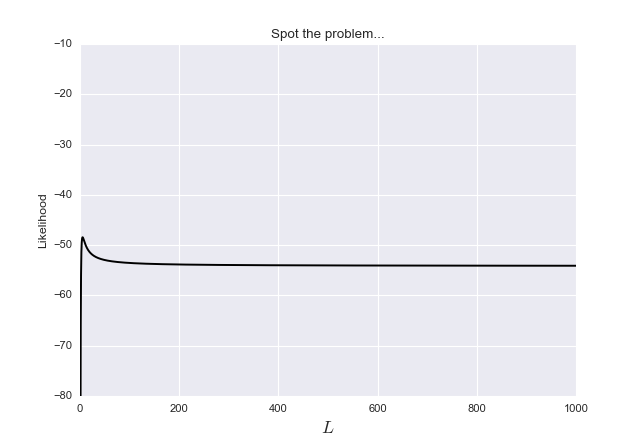

In [37]:
L = np.linspace(1./1000.0, 1000.0, 10001)

like_grid = np.array([llike([l]) for l in L])

plt.figure()
plt.plot(L, like_grid, "k")
plt.xlabel("$L$", fontsize=16)
plt.ylabel("Likelihood")
plt.title("Spot the problem...")
plt.ylim(-80, -10)
plt.show()



Okay, so it looks like it plateaus to the right. Let's run MCMC:

In [38]:
import emcee

In [39]:
start_pars = np.array([200])
start_cov = np.diag(start_pars/100.0)

In [40]:
nwalkers = 2
niter = 200
ndim = len(start_pars)
burnin = 50000

In [41]:
p0 = np.array([np.random.multivariate_normal(start_pars, start_cov) for
               i in range(nwalkers)])


In [42]:
# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, llike, threads=4)



In [43]:
pos, prob, state = sampler.run_mcmc(p0, burnin)

In [44]:
sampler.chain.shape

(2, 50000, 1)

<IPython.core.display.Javascript object>


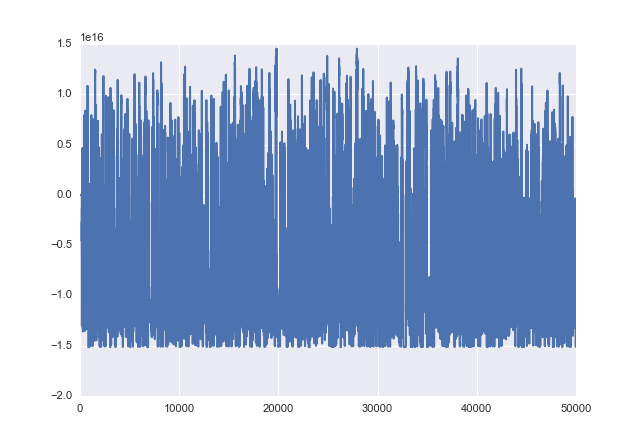

In [45]:
plt.figure()
plt.plot(sampler.chain[0,:])
#plt.yscale("log")

That doesn't look like it's converging.

This problem actually gave me headaches during my PhD until
I thought harder about priors and realised why it was happening.
Consider an $N \times N$ image of a patch of sky. Without any noise,
we'd observe the *true* image, defined by the flux $f$ in each pixel:
\begin{align}
\textbf{true image} &= \left\{f_{ij}\right\}
\end{align}
The true total flux of the patch of sky is
\begin{align}
F &= \sum_{i=1}^N \sum_{i=1}^N f_{ij}.
\end{align}

However, due to noise, we observe a perturbed version of the
flux in each pixel. i.e. our data is noisy fluxes $D_{ij}$,
such that
\begin{align}
p(D_{ij} | f_{ij}) &\sim \textbf{Normal}\left(f_{ij}, \sigma^2\right)
\end{align}
Assuming $\sigma$ is known, the likelihood
we'd need to infer the $f$s from the $D$s
is therefore
\begin{align}
p\left(\{D_{ij}\} | \{f_{ij}\}\right)
&\propto \exp
\left[
  -\frac{1}{2\sigma^2}\sum_{i=1}^N\sum_{j=1}^N
                  \left(D_{ij} - f_{ij}\right)^2
\right].
\end{align}

With this likelihood, we can infer the $f$s
(the de-noised image) from the $D$s (the noisy data).
We know fluxes are non-negative, so $f_{ij} \geq 0$.

With an implicit uniform prior on the $f$s,
try MCMC sampling and using the chain of $f$s to
get a posterior for $F$. You should notice something
"wrong" with it, caused by the uniform prior.

#### Making some fake data

Let's start by simulating some data.

In [206]:
def makeGaussian(size, amp, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return amp*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [207]:
npix = 100
width = 3
pos = [50, 50]
amp = 10.0

image = makeGaussian(npix, amp, fwhm=width, center=pos)


<IPython.core.display.Javascript object>


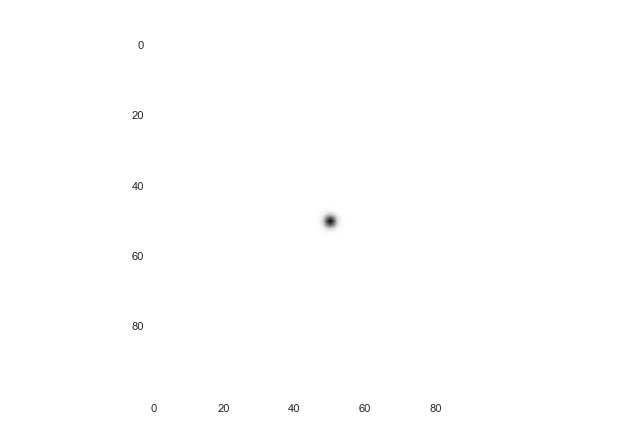

In [208]:
plt.figure()
plt.imshow(image)

In [187]:
img_std = 0.1

image = np.random.normal(image, img_std)

<IPython.core.display.Javascript object>


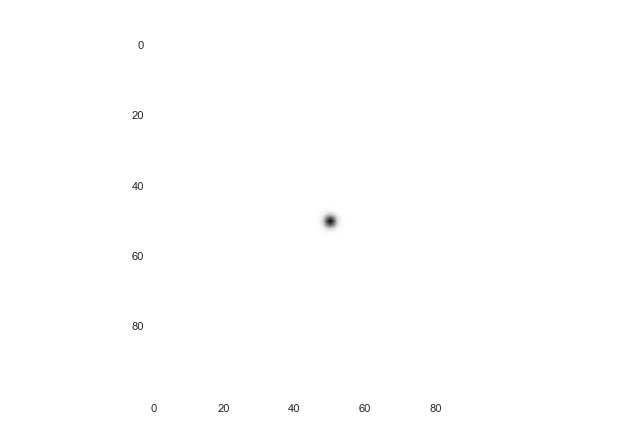

In [209]:
plt.figure()
plt.imshow(image)

None, so we're cool. Let's now write down the Gaussian likelihood:

In [210]:
class ImageLikelihood(object):
    
    def __init__(self, image, model, sigma):
        self.image = image
        self.npix = self.image.shape[0]
        self.model = model
        self.sigma = sigma
        
    def loglikelihood(self, pars):
        mean_model = self.model(np.exp(pars))
        
        loglike = -(0.5/self.sigma**2.)*np.sum((self.image-mean_model)**2.)
        
        if not np.isfinite(loglike):
            return logmin
        
        else:
            return loglike
        
    def __call__(self, pars):
        return self.loglikelihood(pars)

Now we can define our simple flat model:

In [211]:
model = lambda c: makeGaussian(npix, c, fwhm=width, center=pos)

In [212]:
mean_model = model(10)

And instantiate the likelihood function:

In [213]:
llike = ImageLikelihood(image, model, img_std)

In [214]:
llike([10])

-123578335138.00447

Our grid of parameters:

In [215]:
c_test = np.linspace(0, 50, 10000)

In [216]:
llike_grid = []
for c in c_test:
    llike_grid.append(llike([c]))
    
llike_grid = np.array(llike_grid)

In [197]:
np.all(np.isfinite(llike_grid))

True

In [198]:
np.all(np.isfinite(c_test))

True

In [199]:
llike_grid

array([ -2.34406620e+04,  -2.34174957e+04,  -2.33942262e+04, ...,
        -6.71751372e+45,  -6.78503264e+45,  -6.85323021e+45])

In [200]:
np.max(llike_grid)

-2487.7037143312227

In [201]:
np.min(llike_grid)

-6.8532302097644669e+45

<IPython.core.display.Javascript object>


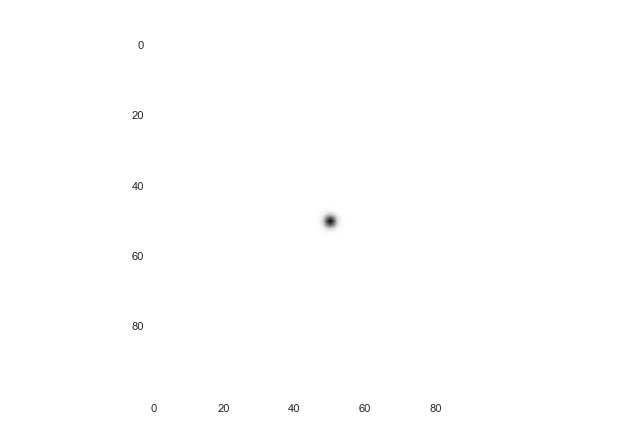

In [202]:
plt.figure()
plt.plot(c_test, llike_grid)
#plt.ylim(-1e30, -2000)

* Fit a straight line with the variance as a parameter with a flat prior
* photoionization grid, try to figure out ionization parameter, but emission lines have been reddened by dust, try to feed in an EB-V, end up with a decreasing exponential distribution from zero, can't place limit on colour access, requires some reparametrization of color access based on column density

